In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import re
import matplotlib.pyplot as plt

In [40]:


# Sample input sentences
sequences = [
    "I wonder what will come next!",
    "This is a basic example paragraph.",
    "Hello, what is a basic split?"
]

# Tokenizer: simple word-level lowercase tokenizer
def tokenize(text):
    return re.findall(r'\w+', text.lower())

# Tokenize
tokenized_sequences = [tokenize(seq) for seq in sequences]

# Build vocabulary
vocab = sorted(set(word for seq in tokenized_sequences for word in seq))
stoi = {word: i for i, word in enumerate(vocab)}
itos = {i: word for word, i in stoi.items()}

# Convert tokens to indices
indexed_sequences = [[stoi[word] for word in seq] for seq in tokenized_sequences]
tensor_sequences = torch.tensor(indexed_sequences).long()  # (batch, seq_len)

# Model hyperparameters
vocab_size = len(stoi)
d_model = 8  # embedding dimension
num_heads = 2
num_encoder_layers = 2
num_decoder_layers = 2
dim_feedforward = 16
dropout = 0.1

# Embeddings with scaling
class Embeddings(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.lut = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

# Positional encoding with sinusoidal pattern
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# Helper: expand mask dims to (batch, heads, query_len, key_len)
def expand_mask(mask):
    if mask is None:
        return None
    while mask.dim() < 4:
        mask = mask.unsqueeze(1)
    return mask

# Scaled dot-product attention
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
    attn = F.softmax(scores, dim=-1)
    out = torch.matmul(attn, v)
    return out, attn

# Multi-head attention module
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv_proj = nn.Linear(input_dim, 3 * embed_dim)
        self.o_proj = nn.Linear(embed_dim, input_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x)  # (B, S, 3*E)
        qkv = qkv.view(batch_size, seq_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)  # (B, H, S, 3*head_dim)
        q, k, v = qkv.chunk(3, dim=-1)  # Each: (B, H, S, head_dim)

        if mask is not None:
            mask = expand_mask(mask)  # (B, 1, S_q, S_k)

        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.permute(0, 2, 1, 3).contiguous()  # (B, S, H, head_dim)
        values = values.view(batch_size, seq_length, self.embed_dim)  # (B, S, E)

        out = self.o_proj(values)

        if return_attention:
            return out, attention
        return out

# Encoder block: MH-attn + FF + norm + dropout
class EncoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(input_dim, input_dim, num_heads)
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)
        return x

# Decoder block: self-attn, cross-attn, FF, norms, dropouts
class DecoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(input_dim, input_dim, num_heads)
        self.cross_attn = MultiHeadAttention(input_dim, input_dim, num_heads)
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.norm3 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output, tgt_mask=None, memory_mask=None):
        self_attn_out = self.self_attn(x, mask=tgt_mask)
        x = x + self.dropout(self_attn_out)
        x = self.norm1(x)

        cross_attn_out = self.cross_attn(x, mask=memory_mask)
        x = x + self.dropout(cross_attn_out)
        x = self.norm2(x)

        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm3(x)
        return x

# Full Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, input_dim, num_heads, dim_feedforward, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderBlock(input_dim, num_heads, dim_feedforward, dropout) for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        att_maps = []
        for layer in self.layers:
            _, attn_map = layer.self_attn(x, mask=mask, return_attention=True)
            att_maps.append(attn_map.detach().cpu())
            x = layer(x, mask=mask)
        return att_maps

# Full Transformer Decoder
class TransformerDecoder(nn.Module):
    def __init__(self, num_layers, input_dim, num_heads, dim_feedforward, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            DecoderBlock(input_dim, num_heads, dim_feedforward, dropout) for _ in range(num_layers)
        ])

    def forward(self, x, encoder_output, tgt_mask=None, memory_mask=None):
        for layer in self.layers:
            x = layer(x, encoder_output, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return x

    def get_attention_maps(self, x, encoder_output, tgt_mask=None, memory_mask=None):
        self_att_maps = []
        cross_att_maps = []
        for layer in self.layers:
            self_out, self_attn_map = layer.self_attn(x, mask=tgt_mask, return_attention=True)
            cross_out, cross_attn_map = layer.cross_attn(x, mask=memory_mask, return_attention=True)
            self_att_maps.append(self_attn_map.detach().cpu())
            cross_att_maps.append(cross_attn_map.detach().cpu())
            x = layer(x, encoder_output, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return self_att_maps, cross_att_maps

# Visualization functions
def plot_attention(attention, title="Attention", xlabel="Key Position", ylabel="Query Position", heads=None):
    # attention shape: (batch, heads, query_len, key_len)
    num_heads = attention.shape[1] if heads is None else heads
    fig, axs = plt.subplots(1, num_heads, figsize=(num_heads * 3, 3))
    if num_heads == 1:
        axs = [axs]
    for i in range(num_heads):
        axs[i].imshow(attention[0, i], cmap='viridis')
        axs[i].set_title(f"{title} Head {i + 1}")
        axs[i].set_xlabel(xlabel)
        axs[i].set_ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def plot_embeddings(embedding_layer, vocab, num_words=10):
    weights = embedding_layer.lut.weight.data.cpu()
    plt.figure(figsize=(8, 6))
    plt.imshow(weights[:num_words], aspect='auto', cmap='viridis')
    plt.yticks(ticks=range(num_words), labels=vocab[:num_words])
    plt.title("Embedding Vectors (First Words)")
    plt.colorbar()
    plt.show()

def plot_positional_encoding(pos_encoding, seq_len=20):
    pe = pos_encoding.pe[0, :seq_len].cpu().numpy().T  # (d_model, seq_len)
    plt.figure(figsize=(12, 4))
    plt.imshow(pe, cmap='coolwarm', aspect='auto')
    plt.xlabel("Position")
    plt.ylabel("Encoding Dimension")
    plt.title("Positional Encoding")
    plt.colorbar()
    plt.show()


def visualize_tokenization(sentences, tokenized_seqs, stoi):
    """
    Visualize tokenization by printing sentences with tokens and indices.

    sentences: list of raw text sentences
    tokenized_seqs: list of list of tokens per sentence
    stoi: dict mapping token -> index
    """
    fig, axs = plt.subplots(len(sentences), 1, figsize=(12, 2 * len(sentences)))
    if len(sentences) == 1:
        axs = [axs]

    for i, (sentence, tokens) in enumerate(zip(sentences, tokenized_seqs)):
        token_indices = [stoi[t] for t in tokens]
        # Prepare text to display: tokens and indices
        token_text = "  ".join(tokens)
        index_text = "  ".join(map(str, token_indices))

        axs[i].text(0, 0.7, f"Sentence: {sentence}", fontsize=12, wrap=True)
        axs[i].text(0, 0.4, f"Tokens:   {token_text}", fontsize=12, color='blue', wrap=True)
        axs[i].text(0, 0.1, f"Indices:  {index_text}", fontsize=12, color='green', wrap=True)

        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [41]:
# Create embedding and positional encoding modules
embeddings = Embeddings(vocab_size, d_model)
pos_encoding = PositionalEncoding(d_model)


# Embed and add positional encoding
embedded = embeddings(tensor_sequences)  # (batch, seq_len, d_model)
pos_encoded = pos_encoding(embedded)

# Create encoder and decoder
encoder = TransformerEncoder(num_encoder_layers, d_model, num_heads, dim_feedforward, dropout)
decoder = TransformerDecoder(num_decoder_layers, d_model, num_heads, dim_feedforward, dropout)

# Forward pass encoder
encoder_output = encoder(pos_encoded)

# Prepare decoder input (simple: same input for demonstration)
decoder_input = pos_encoded.clone()

# Forward pass decoder
decoder_output = decoder(decoder_input, encoder_output)

# Get attention maps
encoder_att_maps = encoder.get_attention_maps(pos_encoded)
decoder_self_att_maps, decoder_cross_att_maps = decoder.get_attention_maps(decoder_input, encoder_output)


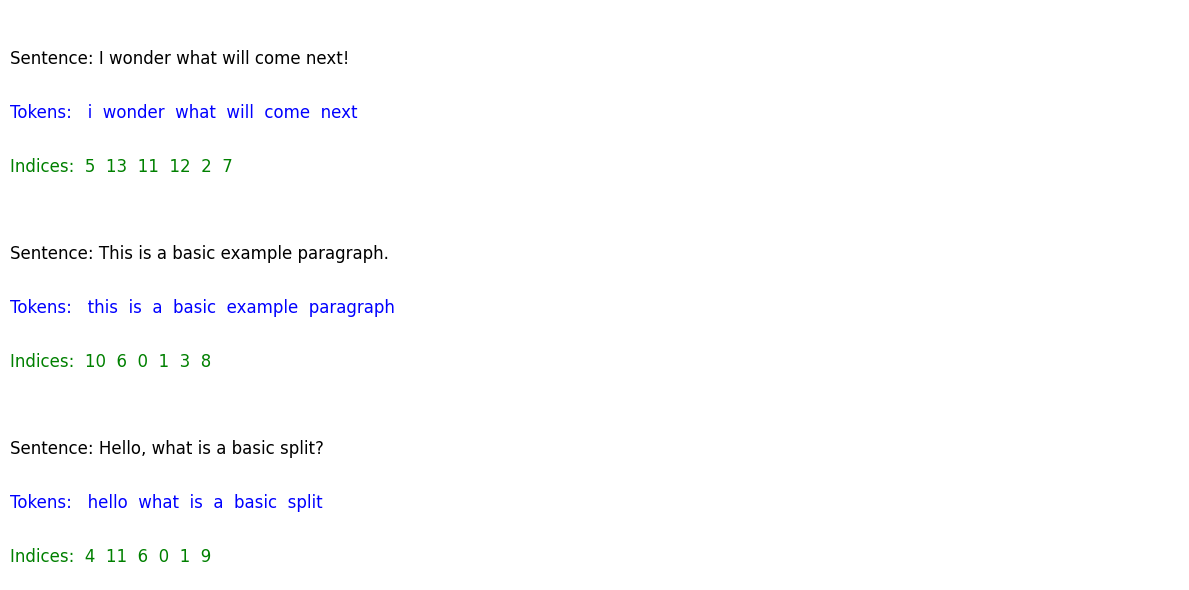

In [43]:
tokenized_seqs = [tokenize(s) for s in sequences]

visualize_tokenization(sequences, tokenized_seqs, stoi)

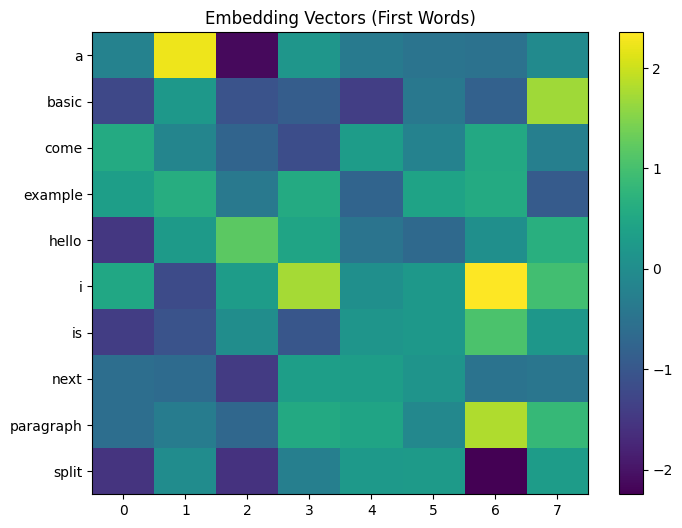

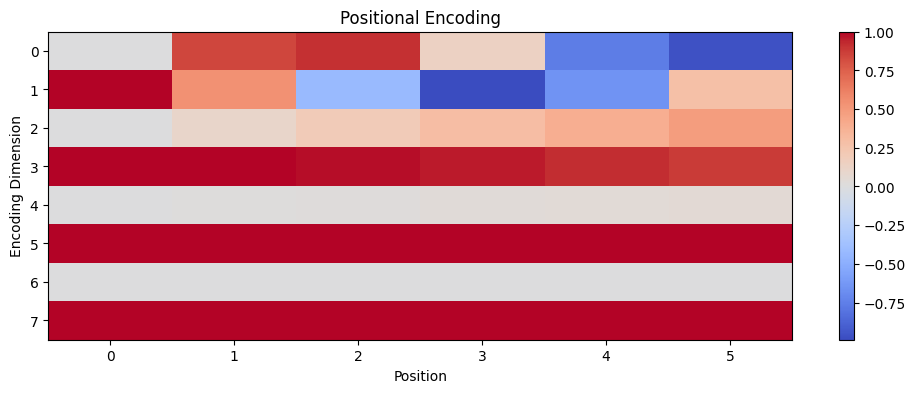

In [44]:
# Visualize embeddings and positional encoding
plot_embeddings(embeddings, vocab)
plot_positional_encoding(pos_encoding, seq_len=tensor_sequences.size(1))

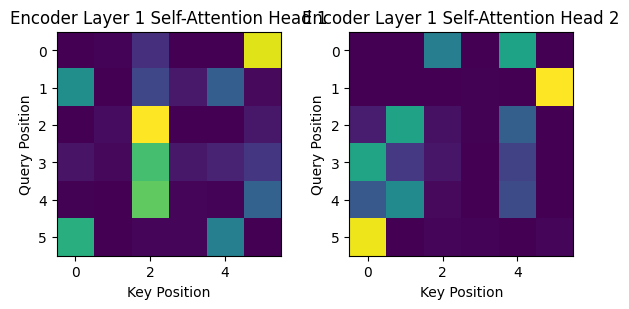

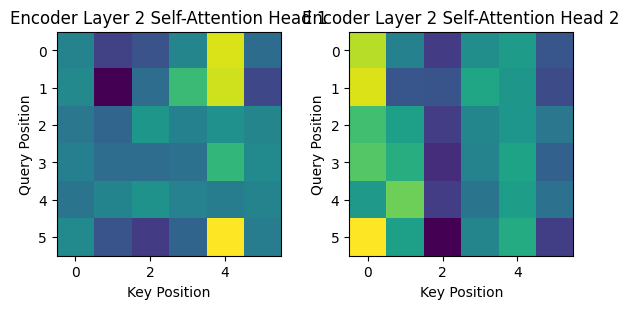

In [34]:
# Plot encoder attention maps
for i, att_map in enumerate(encoder_att_maps):
    plot_attention(att_map, title=f"Encoder Layer  {i + 1} Self-Attention", heads=num_heads)

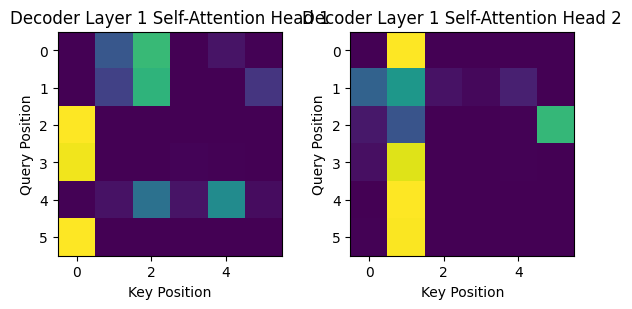

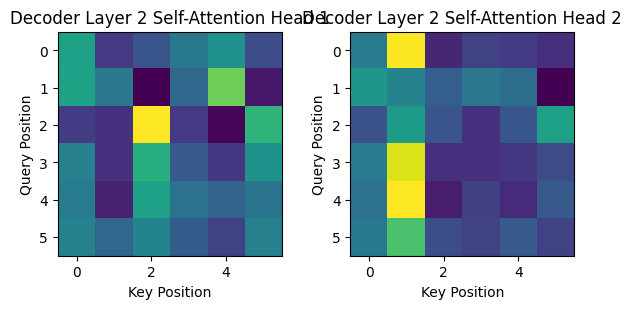

In [35]:
# Plot decoder self-attention maps
for i, att_map in enumerate(decoder_self_att_maps):
    plot_attention(att_map, title=f"Decoder Layer {i + 1} Self-Attention", heads=num_heads)

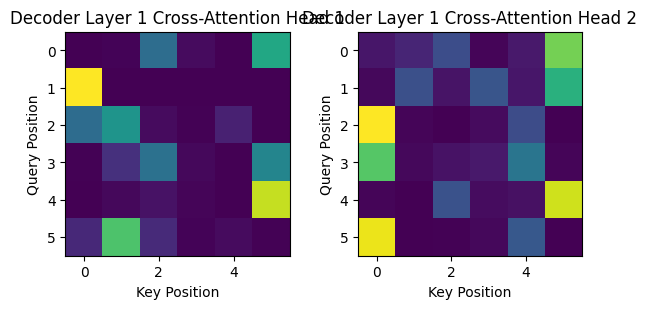

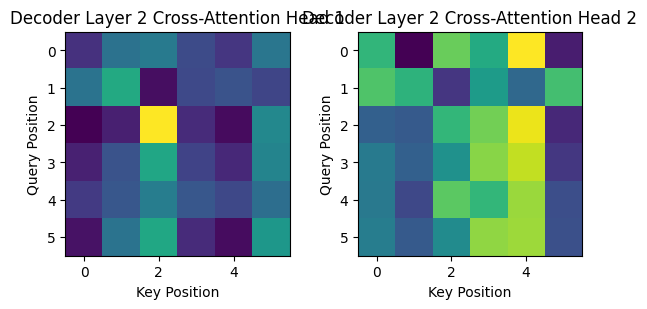

In [36]:
# Plot decoder cross-attention maps
for i, att_map in enumerate(decoder_cross_att_maps):
    plot_attention(att_map, title=f"Decoder Layer {i + 1} Cross-Attention", heads=num_heads)